# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
train_fname = 'tweet_sentiment_train.csv.zip'
raw_df = pd.read_csv(train_fname)

In [17]:
raw_df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [18]:
raw_df.shape

(27481, 4)

In [19]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [20]:
df = raw_df.dropna().copy()

In [21]:
df.isnull().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [22]:
sentiment_counts = df['sentiment'].value_counts()

print("--- Розподіл класів сентименту ---")
print(sentiment_counts)
print("\n--- Частка кожного класу ---")
print(df['sentiment'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

--- Розподіл класів сентименту ---
sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

--- Частка кожного класу ---
sentiment
neutral     40.45%
positive    31.23%
negative    28.32%
Name: proportion, dtype: object


/tmp/ipython-input-2261053241.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


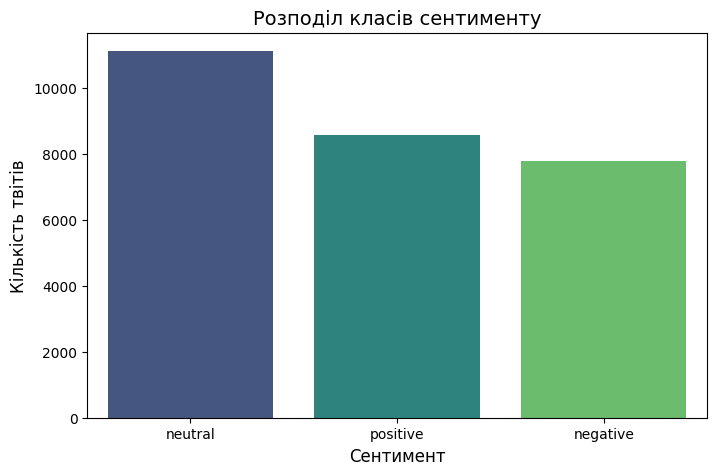

In [23]:
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Розподіл класів сентименту', fontsize=14)
plt.xlabel('Сентимент', fontsize=12)
plt.ylabel('Кількість твітів', fontsize=12)
plt.show()

**Спостереження**

У нас є три класи сентименту: `neutral`, `positive` та `negative`.

Набір даних є відносно збалансованим, оскільки найбільший клас (`neutral`) не домінує критично над іншими. Це добре для навчання класифікатора.

In [24]:
df['text_length'] = df['text'].astype(str).apply(len)

print("--- Статистика довжини текстів ---")
print(df['text_length'].describe())

--- Статистика довжини текстів ---
count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64


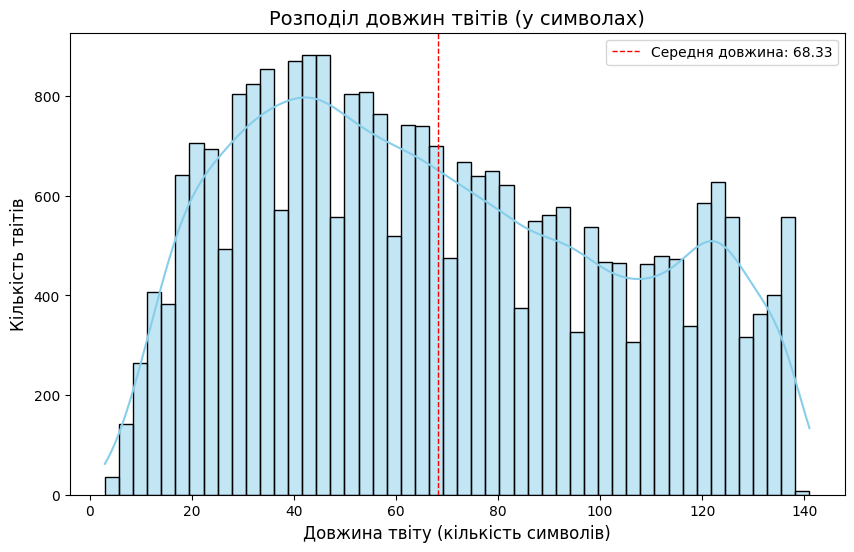

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Розподіл довжин твітів (у символах)', fontsize=14)
plt.xlabel('Довжина твіту (кількість символів)', fontsize=12)
plt.ylabel('Кількість твітів', fontsize=12)
plt.axvline(df['text_length'].mean(), color='red', linestyle='dashed', linewidth=1, label=f'Середня довжина: {df["text_length"].mean():.2f}')
plt.legend()
plt.show()

**Спостереження**

Аналіз довжини твітів показав наступне:
- Середня довжина: 68
- Медіана: 64
- Максимальна довжина: 141

Найбільше постів зосереджено у діапазоні від 20 до 70 символів. На гістограмі видно чіткий пік саме в цій області.

Середня довжина твіту становить 68 символів, а медіана (64 символи) дуже близька до середнього значення, що свідчить про відсутність критичного зміщення розподілу.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
STOPWORDS_EN = stopwords.words('english')
stemmer = SnowballStemmer("english")

In [35]:
data = df['text']

In [36]:
def custom_tokenizer(text):
    if isinstance(text, float):
        return []

    # 1. Перетворення на нижній регістр
    text = text.lower()

    # 2. Видалення URL-адрес, згадок (@user) та хештегів (#tag)
    # Видалення URL-адрес
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Видалення згадок та хештегів
    text = re.sub(r'@\w+|#\w+', '', text)
    # Видалення більшості спеціальних символів, залишаючи лише букви та пробіли
    text = re.sub(r'[^\w\s]', ' ', text)
    # Видалення цифр (опціонально, але часто корисно для сентименту)
    text = re.sub(r'\d+', ' ', text)

    # 3. Токенізація
    tokens = text.split()

    # 4. Видалення стоп-слів та Стеммінг
    stemmed_tokens = [
        stemmer.stem(word)
        for word in tokens
        if word not in STOPWORDS_EN and len(word) > 1
    ]

    return stemmed_tokens

In [37]:
MAX_FEATURES = 15000

In [40]:
bow_vectorizer = CountVectorizer(
    tokenizer=custom_tokenizer,
    max_features=MAX_FEATURES,
    min_df=5
    )

In [42]:
X_bow = bow_vectorizer.fit_transform(data)

y = df['sentiment']

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [44]:
print(f"Розмір словника: {X_bow.shape[1]}")
print(f"Розмір матриці BoW: {X_bow.shape}")

Розмір словника: 3661
Розмір матриці BoW: (27480, 3661)


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [46]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [47]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [48]:
print(f"Розмір X_train_bow: {X_train_bow.shape}")
print(f"Розмір X_test_bow: {X_test_bow.shape}")
print(f"Розмір y_train: {y_train.shape}")
print(f"Розмір y_test: {y_test.shape}")

Розмір X_train_bow: (21984, 3661)
Розмір X_test_bow: (5496, 3661)
Розмір y_train: (21984,)
Розмір y_test: (5496,)


In [51]:
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42, multi_class='auto', max_iter=1000),
    "Linear SVC": LinearSVC(random_state=42, dual=False, max_iter=1000),
    "Multinomial Naive Bayes": MultinomialNB()
}

In [52]:
target_names = le.classes_

target_names

array(['negative', 'neutral', 'positive'], dtype=object)

In [53]:
results = {}

In [60]:
for name, model in models.items():
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"\nМодель: **{name}**")
    print(f"Точність (Accuracy): {accuracy:.4f}")

    print("\nЗвіт класифікації:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Модель: **Logistic Regression**
Точність (Accuracy): 0.6929

Звіт класифікації:
              precision    recall  f1-score   support

    negative       0.71      0.63      0.67      1556
     neutral       0.64      0.72      0.68      2223
    positive       0.76      0.71      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.69      0.69      5496
weighted avg       0.70      0.69      0.69      5496

Confusion Matrix:
 [[ 986  474   96]
 [ 324 1598  301]
 [  73  420 1224]]

Модель: **Linear SVC**
Точність (Accuracy): 0.6707

Звіт класифікації:
              precision    recall  f1-score   support

    negative       0.68      0.63      0.65      1556
     neutral       0.63      0.67      0.65      2223
    positive       0.73      0.70      0.72      1717

    accuracy                           0.67      5496
   macro avg       0.68      0.67      0.67      5496
weighted avg       0.67      0.67      0.67      5496

Confusion M

In [59]:
best_model_name = max(results, key=results.get)
print(f"Найкраща модель за точністю: **{best_model_name}** з результатом {results[best_model_name]:.4f}")

Найкраща модель за точністю: **Logistic Regression** з результатом 0.6929


**Оцінка якості моделі**

Найкращою моделлю виявилася Logistic Regression із точністю 0.6929, що є досить хорошим результатом для початкової моделі PoC на основі простого методу BoW з базовою попередньою обробкою.

Наявність трьох класів означає, що випадкове вгадування дасть точність приблизно 0.33. Наша модель значно перевершує цей показник.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [63]:
best_model = LogisticRegression(solver='liblinear', random_state=42, multi_class='auto', max_iter=1000)
best_model.fit(X_train_bow, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto', random_state=42,
                   solver='liblinear')

In [66]:
feature_names = np.array(bow_vectorizer.get_feature_names_out())

coefs = best_model.coef_

sentiment_classes = ['negative', 'neutral', 'positive']

In [68]:
print("--- Аналіз ТОП-10 найбільш впливових слів ---")

for i, sentiment in enumerate(sentiment_classes):
    # Отримання коефіцієнтів для поточного класу
    class_coefs = coefs[i, :]

    # Сортування індексів ознак за вагою (від найбільшої до найменшої)
    top_indices = class_coefs.argsort()[-10:][::-1]

    # Виведення результатів
    top_features = feature_names[top_indices]
    top_weights = class_coefs[top_indices]

    print(f"\nКлас: **{sentiment.upper()}**:")
    for feature, weight in zip(top_features, top_weights):
        print(f"  - {feature}: {weight:.4f}")

--- Аналіз ТОП-10 найбільш впливових слів ---

Клас: **NEGATIVE**:
  - sad: 3.0237
  - stupid: 2.8418
  - suck: 2.8031
  - bore: 2.7932
  - worst: 2.7496
  - hate: 2.7372
  - wtf: 2.7326
  - fail: 2.7323
  - sorri: 2.6022
  - headach: 2.5549

Клас: **NEUTRAL**:
  - indoor: 1.9993
  - chan: 1.7930
  - colorado: 1.6608
  - jst: 1.6455
  - dd: 1.6356
  - otherwis: 1.5662
  - moro: 1.5609
  - how: 1.5274
  - sp: 1.4476
  - lah: 1.3282

Клас: **POSITIVE**:
  - cute: 3.3471
  - thank: 3.1147
  - awesom: 3.0988
  - amaz: 2.9891
  - love: 2.8309
  - congratul: 2.8293
  - excit: 2.8118
  - nice: 2.7593
  - happi: 2.7138
  - enjoy: 2.6703


**Висновок**

Отримані резульати гарно демонструють кожну категорію твітів.

Слова, що мають найбільший позитивний коефіцієнт для класу `positive`, є емоційно забарвленими, схвальними та радісними, що є абсолютно логічним.

Найбільш впливові слова для класу `negative` пов'язані з прямим вираженням негативних емоцій, скаргами та проблемами.

Слова, які сильно вказують на `neutral`, є переважно функціональними, пов'язаними з повсякденною діяльністю. Вони не є "найменш впливовими" в цілому, але є найбільш впливовими для виділення нейтрального класу, що є абсолютно логічним для класифікатора.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [71]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    max_features=MAX_FEATURES,
)

In [72]:
X_tfidf = tfidf_vectorizer.fit_transform(data)

print(f"Розмір матриці TF-IDF: {X_tfidf.shape}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Розмір матриці TF-IDF: (27480, 15000)


In [73]:
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(
    X_tfidf,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [74]:
print(f"Розмір X_train_tfidf: {X_train_tfidf.shape}")

Розмір X_train_tfidf: (21984, 15000)


In [75]:
tfidf_model = LogisticRegression(solver='liblinear', random_state=42, multi_class='auto', max_iter=1000)
tfidf_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='auto', random_state=42,
                   solver='liblinear')

In [76]:
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)

In [77]:
tfidf_accuracy = accuracy_score(y_test, y_pred_tfidf)

print("--- Результати класифікації (TF-IDF) ---")
print(f"Точність (Accuracy) TF-IDF моделі: {tfidf_accuracy:.4f}")
print("\nЗвіт класифікації (TF-IDF):")
print(classification_report(y_test, y_pred_tfidf, target_names=target_names))

--- Результати класифікації (TF-IDF) ---
Точність (Accuracy) TF-IDF моделі: 0.6887

Звіт класифікації (TF-IDF):
              precision    recall  f1-score   support

    negative       0.74      0.58      0.65      1556
     neutral       0.62      0.77      0.68      2223
    positive       0.78      0.69      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.71      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496



In [78]:
print("--- Аналіз ТОП-10 впливових слів (TF-IDF) ---")

tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
tfidf_coefs = tfidf_model.coef_

for i, sentiment in enumerate(sentiment_classes):
    class_coefs = tfidf_coefs[i, :]
    top_indices = class_coefs.argsort()[-10:][::-1]

    top_features = tfidf_feature_names[top_indices]
    top_weights = class_coefs[top_indices]

    print(f"\nКлас: **{sentiment.upper()}** (топ-10 слів TF-IDF):")
    for feature, weight in zip(top_features, top_weights):
        print(f"  - {feature}: {weight:.4f}")

--- Аналіз ТОП-10 впливових слів (TF-IDF) ---

Клас: **NEGATIVE** (топ-10 слів TF-IDF):
  - sad: 7.0683
  - miss: 6.5054
  - sorri: 6.1055
  - hate: 5.9056
  - suck: 5.6881
  - bore: 5.2776
  - stupid: 5.0285
  - hurt: 4.9155
  - fail: 4.7814
  - poor: 4.5144

Клас: **NEUTRAL** (топ-10 слів TF-IDF):
  - guitar: 1.6212
  - indoor: 1.5517
  - tho: 1.5509
  - except: 1.5101
  - differ: 1.4252
  - moro: 1.3846
  - goin: 1.2793
  - knock: 1.2769
  - list: 1.2765
  - lol: 1.2453

Клас: **POSITIVE** (топ-10 слів TF-IDF):
  - love: 8.8713
  - thank: 7.9368
  - happi: 6.5981
  - good: 6.4557
  - awesom: 6.4338
  - great: 6.2231
  - nice: 6.1366
  - amaz: 5.6081
  - hope: 5.4440
  - excit: 5.1892


**Спостереження**

###Аналіз якості класифікації

Якість класифікації практично не змінилася.

1. Модель BoW показала трохи кращий результат Accuracy - 0.6929, порівняно з TF-IDF - 0.6887. Це невелике, але несподіване зниження.

2. Weighted F1-score для обох моделей становить 0.69, що свідчить про ідентичну загальну здатність моделей розрізняти класи, враховуючи їхній розмір.

В даному експерименті TF-IDF не зробила якість класифікації кращою за показниками Accuracy та Weighted F1-score.

###Порівняння впливовості токенів

1. Клас NEGATIVE

BoW показує очцкувані слова-маркери для неготивно-забарвдених твітів. TF-IDF робить те саме, але ваги значно вищі (7 проти 3), оскільки TF-IDF підсилює унікальність цих емоційних слів відносно всього корпусу.

2. Клас NEUTRAL

BoW виділяє низько-емоційні, предметні слова. У TF-IDF має схожий набір предметних/функціональних слів. TF-IDF виділяє слова, які з'являються часто в нейтральному контексті, але рідко в емоційному. Ці слова мають нижчу вагу порівняно з емоційними класами, що логічно.

3. Клас POSITIVE

І BoW, і TF-IDF виявляють прямі позитивні маркери та подяки. Як і з негативними маркерами, TF-IDF має ваги значно вищі 8.87 проти 3.35, підсилюючи інформативність позитивних слів.

**Вибір для фінальної імплементації**

Оскільки різниця в якості мізерна, можна обрати найпростіший метод, що дає найкращий результат — це BoW.

BoW може показати себе більш стабільним, бо менш чутливий до рідкісних, але помилково підсилених TF-IDF слів. Можливо в рамках твітів це буде мати більше сенсу.

Але задля більш глибшого розуміння обох підходів я б все одно ще більше поковирялася б з TF-IDF.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

**Аналіз помилок**

Основні проблеми:

1. Клас `Negative` (низький Recall 0.58) означає що модель знаходить лише 58% справжніх негативних твітів. Багато негативних твітів помилково класифікуються як інші класи, ймовірно, як `neutral` або `positive`.

2. Клас `Neutral` (низький Precision 0.62) означає, що з усіх твітів, які модель позначила як 'neutral', лише 62% дійсно були нейтральними. Багато емоційних твітів помилково позначаються як `neutral`.

3. Найбільш поширені помилки, ймовірно, відбуваються на межі `negative` / `neutral` та `positive` / `neutral`. Думаю це доволі стандартна проблема, коли нейтральні тексти містять емоційно неоднозначні або слабкі слова.

###Шляхи поліпшення якості класифікації

1. Покращення попередньої обробки: зменшити шум, замінивши стеммінг (який обрізає слова) на лемматизацію (яка повертає слова до словникової форми) та посилити роботу з емоційними символами.

2. Включення N-грам та синтаксису (Розширення ознак). Такій підхід поможе подолати обмеження BoW/TF-IDF, які ігнорують порядок слів, додавши послідовності слів, що в свою чергу допоможе моделі розпізнавати заперечення (фрази на зразок 'not good' проти 'good'. У BoW/TF-IDF обидва слова 'not' та 'good' мають незалежний вплив, тоді як N-грами кодують 'not good' як єдину негативну ознаку.), та стійкі вирази.

3. Перейти від простих лінійних моделей на основі частот до моделей, які розуміють семантичний контекст слів. Це, як я розумію, більш складний шлях, і ми ще таке не проходили, але попередній аналіз таких інструментів, як наприклад Word Embeddings, може суттєво допомогти моделі краще узагальнювати емоції, особливо у випадку, коли лінійна модель плутає 'negative' і 'neutral'.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model